## Import Packages

In [1]:
import os
import numpy as np
import pandas as pd
import polars as pl
import warnings

import json

import matplotlib.pyplot as plt
from mplsoccer import Pitch

from matplotlib.colors import LinearSegmentedColormap, Normalize
import matplotlib.cm as cm

warnings.simplefilter(action = 'ignore', category = FutureWarning)
pl.Config.set_tbl_width_chars(150)
pl.Config.set_tbl_rows(1000)
pl.Config.set_tbl_cols(20)

custom_cmap = LinearSegmentedColormap.from_list("custom_orange_red", ["white", "blue", "navy"])

## Import Data

In [2]:
df_matches = pl.read_parquet("/mnt/block/data/final_datasets/match_detail.parquet")
df_players = pl.read_parquet("/mnt/block/data/final_datasets/player_performance.parquet")
df_tags    = pl.read_csv('/mnt/block/data/raw_data/tags2name.csv')
df_events  = pl.read_csv('/mnt/block/data/raw_data/eventid2name.csv')

In [3]:
print(f"df_matches: {df_matches.columns}")
print(f"df_players: {df_players.columns}")
print(f"df_tags: {df_tags.columns}")
print(f"df_events: {df_events.columns}")

df_matches: ['matchId', 'matchPeriod', 'eventSec', 'eventId', 'eventName', 'subEventId', 'subEventName', 'id', 'playerId', 'teamId', 'positions', 'tag_1', 'tag_2', 'tag_3', 'tag_4', 'tag_5', 'tag_6', 'tag_1_name', 'tag_2_name', 'tag_3_name', 'tag_4_name', 'tag_5_name', 'tag_6_name']
df_players: ['Id', 'firstName', 'middleName', 'lastName', 'full_name', 'birthDay', 'age', 'weight', 'height', 'foot', 'club', 'currentTeamId', 'national_team', 'currentNationalTeamId', 'country_of_birth', 'city_of_birth', 'country_of_citizenship', 'position', 'Role', 'status', 'market_value_in_eur', 'highest_market_value_in_eur', 'contract_expiration_date', 'agent_name', 'UrlFBref', 'image_url', 'UrlTmarkt', 'TMarketID', 'WyScoutID', 'StatsBombID', 'FBrefID', 'Matches Played', 'Total Shots', 'Accurate Shots', 'Shot Accuracy', 'Goals', 'Shot Conversion', 'Penalties Taken', 'Penalties Scored', 'Penalty Conversion', 'Total Passes', 'Accurate Passes', 'Pass Accuracy', 'Key Passes', 'Assists', 'Run Attempts With

In [4]:
print("Unique values in Description:", df_tags['Description'].unique())
print("Unique values in event_label:", df_events['event_label'].unique())
print("Unique values in subevent_label:", df_events['subevent_label'].unique())
print("Unique values in event_label, subevent_label:", df_events['event_label', 'subevent_label'].unique().sort(by = 'event_label'))

Unique values in Description: shape: (59,)
Series: 'Description' [str]
[
	"Through"
	"Position: Goal high center"
	"Anticipated"
	"Position: Goal center right"
	"Opportunity"
	"Red card"
	"Low"
	"Position: Out center left"
	"Position: Goal center left"
	"Position: Goal low left"
	"Blocked"
	"Missed ball"
	"Take on right"
	"Key pass"
	"Head/body"
	"Position: Out high right"
	"Position: Goal high left"
	"Neutral"
	"Position: Post low right"
	"Counter attack"
	"Position: Post high right"
	"Take on left"
	"Position: Out low left"
	"Position: Out center right"
	"Won"
	"Left foot"
	"Clearance"
	"Free space right"
	"Position: Post high center"
	"Right foot"
	"Free space left"
	"Interception"
	"Indirect"
	"Second yellow card"
	"Position: Post high left"
	"Position: Goal center"
	"Anticipation"
	"Yellow card"
	"Assist"
	"Feint"
	"Sliding tackle"
	"Position: Post center left"
	"Position: Goal high right"
	"Fairplay"
	"Accurate"
	"Not accurate"
	"Own goal"
	"Goal"
	"Position: Goal low right"
	"Po

In [20]:
include_events = ["Pass", "Shot", "Others on the ball", "Duel", "Save attempt", "Goalkeeper leaving line"]
df_heatmaps    = df_matches.filter(pl.col("eventName").is_in(include_events))

## Testing

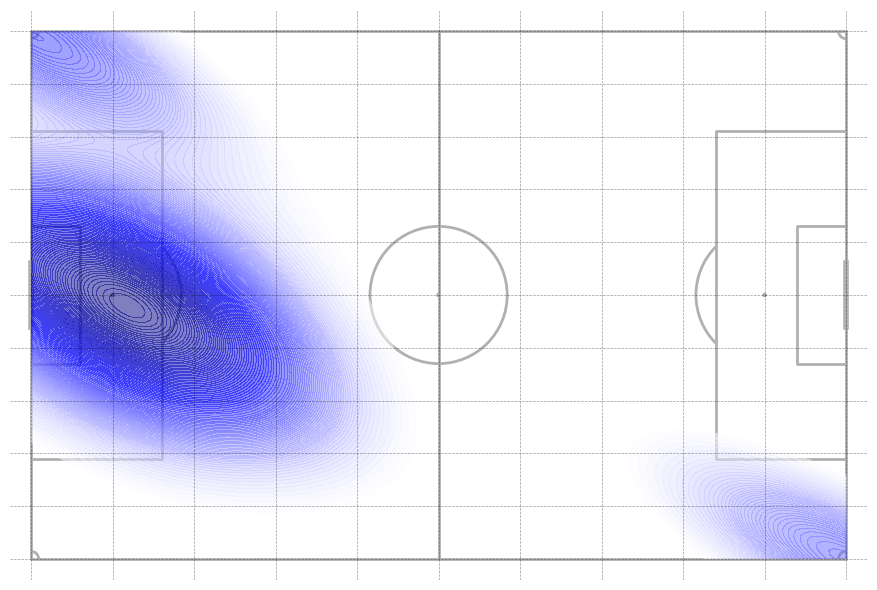

In [21]:
# Filter for the player
player_id = 7848
df_player = df_heatmaps.filter(pl.col("playerId") == player_id)

# Extract positions
positions = [(pos[0]['x'], pos[0]['y'])
             for pos in df_player['positions'].to_list()
             if pos and isinstance(pos, list) and len(pos) > 0]

# Separate x and y coordinates
x = [pos[0] for pos in positions]
y = [pos[1] for pos in positions]

# Plotting
pitch = Pitch(pitch_type = 'wyscout', corner_arcs = True)
fig, ax = pitch.draw(figsize = (10, 6))

pitch.kdeplot(x, y, ax = ax, cmap = custom_cmap, shade = True, levels = 100, alpha = 0.5)

ax.set_xticks(range(0, 101, 10))
ax.set_yticks(range(0, 101, 10))
ax.grid(color = 'black', linestyle = '--', linewidth = 0.5, alpha = 0.4)

plt.show()

## Save heatmaps

In [22]:
# Ensure plots/ directory exists
os.makedirs("plots", exist_ok = True)

# Get all unique player IDs
player_ids = df_heatmaps.select("playerId").unique().to_series().to_list()

# Set up the pitch object once
pitch = Pitch(pitch_type = 'wyscout', corner_arcs = True)

# Dictionary to store player feature vectors
player_features = []

# Define grid size
grid_size = (10, 10)  # 10x10 grid

# Loop over each player ID
for player_id in player_ids:
    filename = f"plots/density_plots/{player_id}.png"

    # Check if heatmap already exists
    if os.path.exists(filename):
        print(f"Skipping player {player_id} (already exists).")
        continue

    df_player = df_heatmaps.filter(pl.col("playerId") == player_id)

    # Extract valid positions
    positions = [(pos[0]['x'], pos[0]['y'])
                 for pos in df_player['positions'].to_list()
                 if pos and isinstance(pos, list) and len(pos) > 0]

    # Skip if too few points
    if len(positions) < 5:
        print(f"Not enough data for player {player_id}. Skipping.")
        continue

    x = [pos[0] for pos in positions]
    y = [pos[1] for pos in positions]

    try:
        # --- Plot the KDE heatmap ---
        fig, ax = pitch.draw(figsize = (10, 6))
        pitch.kdeplot(x, y, ax = ax, cmap = custom_cmap, shade = True, levels = 100, alpha = 0.4)
        ax.set_xticks(range(0, 101, 10))
        ax.set_yticks(range(0, 101, 10))
        ax.grid(color = 'black', linestyle = '--', linewidth = 0.5, alpha = 0.4)
        # ax.set_title(f'Event Heatmap for Player {player_id}', fontsize = 16)
        plt.savefig(filename, dpi = 150, bbox_inches = 'tight')
        plt.close(fig)
        print(f"Saved heatmap for player {player_id}.")

        # --- Extract gridded density vector (feature) ---
        heatmap_vector, _, _ = np.histogram2d(x, y, bins = grid_size, range = [[0, 100], [0, 100]])
        # Normalize to sum to 1 (density)
        heatmap_vector = heatmap_vector.flatten()
        heatmap_vector = heatmap_vector / heatmap_vector.sum()

        player_features.append({"playerId": player_id,
                                "features": heatmap_vector.tolist()
                              })

    except Exception as e:
        print(f"Error plotting/extracting for player {player_id}: {e}")
        continue

Saved heatmap for player 12242.
Saved heatmap for player 82340.
Saved heatmap for player 14864.
Saved heatmap for player 134399.
Saved heatmap for player 3866.
Saved heatmap for player 9279.
Saved heatmap for player 69409.
Saved heatmap for player 346913.
Saved heatmap for player 26138.
Saved heatmap for player 208694.
Saved heatmap for player 25867.
Saved heatmap for player 25800.
Saved heatmap for player 105320.
Saved heatmap for player 114617.
Saved heatmap for player 21098.
Saved heatmap for player 16303.
Saved heatmap for player 25577.
Saved heatmap for player 139080.
Saved heatmap for player 15012.
Saved heatmap for player 127537.
Saved heatmap for player 99452.
Saved heatmap for player 3322.
Saved heatmap for player 278867.
Saved heatmap for player 145692.
Saved heatmap for player 9403.
Saved heatmap for player 25999.
Saved heatmap for player 198120.
Saved heatmap for player 8245.
Saved heatmap for player 278872.
Saved heatmap for player 230862.
Saved heatmap for player 91122.
S

## Heatmaps to JSON

In [27]:
with open("/mnt/block/data/final_datasets/player_heatmap_features.json", "w") as f:
    json.dump(player_features, f, indent = 2)